In [172]:
import torch
import numpy as np
import os
import json
import joblib
from torch.utils.data import Dataset,DataLoader
from itertools import repeat
import pandas as pd
import math
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from torch.autograd import Variable

import wandb
import logging
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os

logger = logging.getLogger(__name__)
wandb_logger = lambda dir, version: WandbLogger(
    name="wandb", save_dir=dir, version=version
)
csvlogger = lambda dir, version: CSVLogger(dir, name="csvlogs", version=version)
tblogger = lambda dir, version: TensorBoardLogger(dir, name="tblogs", version=version)

def get_loggers(dir,version,lis=["csv"]):
    lgrs = []
    if "wandb" in lis:
        lgrs.append(wandb_logger(dir, version))
    if "csv" in lis:
        lgrs.append(csvlogger(dir, version))
    if "tb" in lis:
        lgrs.append(tblogger(dir, version))
    return lgrs


from pathlib import Path
data_dir =Path('/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/')
image_dir = Path('/common/users/vk405/EnergyLab/Data')
proc_data_dir = Path('/common/users/vk405/EnergyLab/Data/ProcData')
df = pd.read_csv(f'{data_dir}/tgtimgs.csv')

class Dset(Dataset):
    def __init__(self,split= 'train',data_dir='/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/',
    image_dir='/common/users/vk405/EnergyLab/Data/ProcData'):
        self.split = split

        #hardcoded dir locs 
        self.data_dir = Path(data_dir)
        self.image_dir = Path(image_dir) 
        
        base_df = pd.read_csv(f'{self.data_dir}/tgtimgs.csv')
        base_df.loc[base_df.index[base_df['Target']>=1250.0],'Target'] = 1250.0
        
        trn_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
        self.scalar = MinMaxScaler().fit(trn_df['Target'].values.reshape(-1,1))
        #splits are hardcoded as per the original paper
        if self.split == 'train':
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
            
        elif self.split == 'valid':
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year == 2015])
            
        else:
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year > 2015])
        #set an upper-threshold.
        self.df.loc[self.df.index[self.df['Target']>=1250.0],'Target'] = 1250.0
        #self.df[self.df['Target']>=1300.0]['Target'] = 1300.0
        rescaled = self.scalar.transform(self.df['Target'].values.reshape(-1,1))
        self.df['Target'] = np.squeeze(rescaled)
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self,ind):
        try:
            imgs = sorted(eval(self.df.iloc[ind]['Imgs']),key = lambda x: int(x.split('/')[-1].split('.')[0]))
            target = self.df.iloc[ind]['Target']
            #image_dir = Path('/common/users/vk405/EnergyLab/Data/ProcData') 
            proc_imgs = [self.image_dir/(x.split('/')[-1].split('.')[0]+'.joblib') for x in imgs]
            proc_arrays = [joblib.load(ele) for ele in proc_imgs]
        except:
            print(ind)
            
        return (np.concatenate(proc_arrays,-1).reshape(-1,256,256))/255.0,target




    

In [4]:
base_df = pd.read_csv(f'{data_dir}/tgtimgs.csv')
base_df.head()

,Date,MST,Imgs,Target
0,2012-01-01,07:40,['/common/users/vk405/EnergyLab/Data/20120101/...,26.5878
1,2012-01-01,07:50,['/common/users/vk405/EnergyLab/Data/20120101/...,42.4806
2,2012-01-01,08:00,['/common/users/vk405/EnergyLab/Data/20120101/...,68.4412
3,2012-01-01,08:10,['/common/users/vk405/EnergyLab/Data/20120101/...,89.9590
4,2012-01-01,08:20,['/common/users/vk405/EnergyLab/Data/20120101/...,100.7435


In [6]:
dt_lis = []
for i in tqdm(range(len(base_df))):
    dt = ' '.join([base_df.iloc[i]['Date'],base_df.iloc[i]['MST']])
    dt_lis.append(dt)

100%|██████████| 100887/100887 [00:15<00:00, 6513.12it/s]


In [8]:
base_df['DateTime'] =  dt_lis

In [14]:
base_df.tail()

,Date,MST,Imgs,Target,DateTime
100882,2017-11-30,15:20,['/common/users/vk405/EnergyLab/Data/20171130/...,161.97970,2017-11-30 15:20
100883,2017-11-30,15:30,['/common/users/vk405/EnergyLab/Data/20171130/...,133.98670,2017-11-30 15:30
100884,2017-11-30,16:00,['/common/users/vk405/EnergyLab/Data/20171130/...,47.26993,2017-11-30 16:00
100885,2017-11-30,16:10,['/common/users/vk405/EnergyLab/Data/20171130/...,15.55378,2017-11-30 16:10
100886,2017-11-30,16:20,['/common/users/vk405/EnergyLab/Data/20171130/...,9.61039,2017-11-30 16:20


In [11]:
df_svd = pd.read_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'))
df_svd.head(2)

,Date,MST,GHI,DateTime
0,2012-01-01,07:25,10.991,2012-01-01 07:25
1,2012-01-01,07:26,12.329,2012-01-01 07:26


In [20]:
base_df['GHI'] = df_svd[df_svd['DateTime'].isin(set(base_df['DateTime']))].sort_values(['Date','MST'])['GHI'].values

In [23]:
base_df.iloc[0]['Imgs']

"['/common/users/vk405/EnergyLab/Data/20120101/20120101074000.raw.jpg', '/common/users/vk405/EnergyLab/Data/20120101/20120101073000.raw.jpg']"

In [24]:
ind = 0
imgs = sorted(eval(base_df.iloc[ind]['Imgs']),key = lambda x: int(x.split('/')[-1].split('.')[0]))

In [31]:
proc_imgs = [proc_data_dir/(x.split('/')[-1].split('.')[0]+'.joblib') for x in imgs]


In [32]:
proc_arrays = [joblib.load(ele) for ele in proc_imgs]

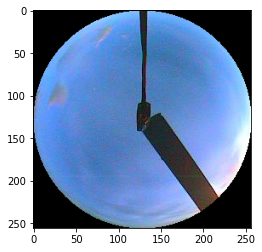

In [35]:
import matplotlib.pyplot as plt
plt.imshow(proc_arrays[0])


In [38]:
base_df['GHI'].quantile(0.50)

455.96

In [50]:
quant_val = 0.5
ind = base_df[base_df['GHI'] == base_df['GHI'].quantile(quant_val)].index.tolist()[0]

In [43]:
imgs = sorted(eval(base_df.iloc[ind]['Imgs']),key = lambda x: int(x.split('/')[-1].split('.')[0]))

In [44]:
proc_imgs = [proc_data_dir/(x.split('/')[-1].split('.')[0]+'.joblib') for x in imgs]
proc_arrays = [joblib.load(ele) for ele in proc_imgs]


In [45]:
proc_imgs

[PosixPath('/common/users/vk405/EnergyLab/Data/ProcData/20140122121000.joblib'),
 PosixPath('/common/users/vk405/EnergyLab/Data/ProcData/20140122122000.joblib')]

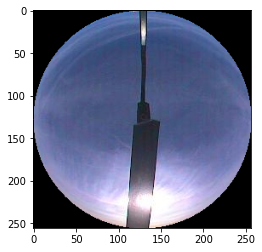

In [51]:
import matplotlib.pyplot as plt
plt.imshow(proc_arrays[0])


In [71]:
base_df[(base_df['GHI'] >= 400.0) & (base_df['GHI'] < 405.0)].index.tolist()

[195,
 285,
 500,
 526,
 903,
 1446,
 2347,
 2572,
 2700,
 2987,
 3148,
 3553,
 3814,
 3933,
 3990,
 4173,
 4469,
 4619,
 4862,
 5129,
 5623,
 6003,
 6312,
 6394,
 6699,
 6871,
 7234,
 7308,
 7436,
 7515,
 7528,
 7938,
 8005,
 8508,
 9315,
 9343,
 10155,
 10231,
 10298,
 10332,
 10752,
 11148,
 11252,
 11468,
 11522,
 11662,
 11930,
 12318,
 12612,
 12717,
 12727,
 12886,
 13076,
 13269,
 13471,
 13662,
 13772,
 13880,
 14351,
 14378,
 14705,
 14981,
 15100,
 15646,
 15767,
 15855,
 15915,
 15964,
 16127,
 16158,
 16431,
 16872,
 17090,
 17140,
 17147,
 17523,
 17803,
 18106,
 18317,
 18318,
 18438,
 18495,
 18605,
 18639,
 18962,
 19176,
 19200,
 19286,
 19497,
 19514,
 19741,
 19927,
 20140,
 20211,
 20212,
 20465,
 20499,
 20520,
 20747,
 20849,
 20955,
 21026,
 21068,
 21303,
 21377,
 21672,
 21734,
 22261,
 22491,
 22842,
 23459,
 24168,
 24690,
 24832,
 24834,
 24901,
 25053,
 25560,
 25596,
 25602,
 25655,
 26054,
 26896,
 27222,
 27702,
 27962,
 28647,
 28724,
 29105,
 29161,
 

In [78]:
def show_image(ind):
    imgs = sorted(eval(base_df.iloc[ind]['Imgs']),key = lambda x: int(x.split('/')[-1].split('.')[0]))
    proc_imgs = [proc_data_dir/(x.split('/')[-1].split('.')[0]+'.joblib') for x in imgs]
    proc_arrays = [joblib.load(ele) for ele in proc_imgs]
    import matplotlib.pyplot as plt
    print(f"GHI:{base_df.iloc[ind]['GHI']}")
    plt.imshow(proc_arrays[-1])
    #plt.imshow(proc_arrays[0])


    


GHI:403.4


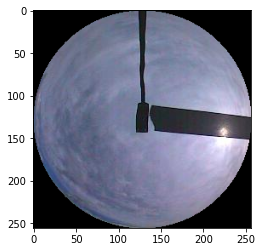

In [79]:
#500,903
show_image(6394)

GHI:401.24


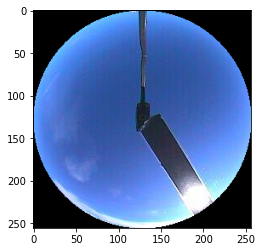

In [80]:
show_image(500)

In [ ]:
#both have same GHI, it seems the irradiance can't be predicted by just cloudiness but also sun intensity which is 
#reflected in the image.

In [81]:
tst_preds = pd.read_csv(data_dir/'infered_vals.csv')

In [86]:
#tst_preds['abs_error'] = np.abs(tst_preds['ground']-tst_preds['pred'])
tst_preds['error'] = tst_preds['pred']-tst_preds['ground']
tst_preds['error'].mean()

small,med = tst_preds['Target'].quantile(0.33),tst_preds['Target'].quantile(0.66)

cloudy = tst_preds[tst_preds['Target']<=small]
normal = tst_preds[(tst_preds['Target']>small) & (tst_preds['Target']<=med)]
sunny = tst_preds[(tst_preds['Target']>med)]

In [87]:
cloudy

,Date,MST,pred,ground,Target,error
29,2016-01-01,14:50,0.424484,0.236853,0.236853,0.187631
30,2016-01-01,15:00,0.430302,0.214433,0.214433,0.215869
31,2016-01-01,15:10,0.430408,0.191809,0.191809,0.238599
32,2016-01-01,15:20,0.358898,0.168426,0.168426,0.190472
33,2016-01-01,15:30,0.355700,0.144628,0.144628,0.211072
...,...,...,...,...,...,...
27845,2017-11-30,15:20,0.152156,0.129584,0.129584,0.022573
27846,2017-11-30,15:30,0.151069,0.107189,0.107189,0.043879
27847,2017-11-30,16:00,0.107605,0.037816,0.037816,0.069789
27848,2017-11-30,16:10,0.076664,0.012443,0.012443,0.064221


In [90]:
base_df[base_df['DateTime'].isin(['2016-01-01 14:50'])]['Imgs']

73066    ['/common/users/vk405/EnergyLab/Data/20160101/...
Name: Imgs, dtype: object

GHI:311.525


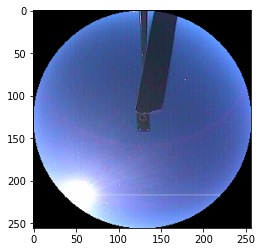

In [91]:
#clear_sky = 73066
show_image(73066)

In [134]:
#building a baseline model using irradiance

base_df.loc[base_df.index[base_df['GHI']>=1250.0],'GHI'] = 1250.0
base_df.loc[base_df.index[base_df['Target']>=1250.0],'Target'] = 1250.0

trn_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])


In [135]:
scalar = MinMaxScaler().fit(trn_df['GHI'].values.reshape(-1,1))

scalar_tgt = MinMaxScaler().fit(trn_df['Target'].values.reshape(-1,1))

In [136]:
trn_df['norm_GHI'] = np.squeeze(scalar.transform(trn_df['GHI'].values.reshape(-1,1)))
trn_df['norm_Target'] = np.squeeze(scalar.transform(trn_df['Target'].values.reshape(-1,1)))

In [143]:
trn_df.head(2)

,Date,MST,Imgs,Target,DateTime,GHI,norm_GHI,norm_Target
0,2012-01-01,07:40,['/common/users/vk405/EnergyLab/Data/20120101/...,26.5878,2012-01-01 07:40,20.072,0.016058,0.021270
1,2012-01-01,07:50,['/common/users/vk405/EnergyLab/Data/20120101/...,42.4806,2012-01-01 07:50,32.264,0.025811,0.033984


In [157]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    dates = sorted(set(data['Date']))
    for date in tqdm(dates):
        #print(date)
        dt_data = data[data['Date'].isin([date])]
        for i in range(len(dt_data)-seq_length-1):
            _x = dt_data.iloc[i:(i+seq_length)]['norm_GHI']
            _y = dt_data.iloc[i+seq_length]['norm_Target']
            x.append(_x)
            y.append(_y)
        

    return np.array(x),np.array(y)

In [158]:
x,y = sliding_windows(trn_df,10)

100%|██████████| 1075/1075 [00:08<00:00, 119.76it/s]


In [165]:
x.shape,y.shape

((46731, 10), (46731,))

## Building an lstm model for predicting future irradiance

In [184]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers,seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [185]:
class Dset(Dataset):
    def __init__(self,split= 'train',data_dir='/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/',
    image_dir='/common/users/vk405/EnergyLab/Data/ProcData',seq_length=10):
        self.split = split

        #hardcoded dir locs 
        self.data_dir = Path(data_dir)
        self.image_dir = Path(image_dir) 
        self.seq_length = seq_length
        
        base_df = pd.read_csv(f'{self.data_dir}/tgtimgs.csv')
        dt_lis = []
        for i in tqdm(range(len(base_df))):
            dt = ' '.join([base_df.iloc[i]['Date'],base_df.iloc[i]['MST']])
            dt_lis.append(dt)
        base_df['DateTime'] =  dt_lis
        
        df_svd = pd.read_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'))
        base_df['GHI'] = df_svd[df_svd['DateTime'].isin(set(base_df['DateTime']))].sort_values(['Date','MST'])['GHI'].values
        
        base_df.loc[base_df.index[base_df['GHI']>=1250.0],'GHI'] = 1250.0
        base_df.loc[base_df.index[base_df['Target']>=1250.0],'Target'] = 1250.0

        trn_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
        scalar = MinMaxScaler().fit(trn_df['GHI'].values.reshape(-1,1))

        scalar_tgt = MinMaxScaler().fit(trn_df['Target'].values.reshape(-1,1))
        if self.split == 'train':
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
        elif self.split == 'valid':
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year == 2015])
        else:
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year > 2015])
            
        self.df['norm_GHI'] = np.squeeze(scalar.transform(self.df['GHI'].values.reshape(-1,1)))
        self.df['norm_Target'] = np.squeeze(scalar_tgt.transform(self.df['Target'].values.reshape(-1,1)))  
        self.x,self.y = self.sliding_windows(self.df,self.seq_length)
        

    def __len__(self):
        return len(self.x)

    def __getitem__(self,ind):
        return x[ind],y[ind]

    def sliding_windows(self,data, seq_length):
        x = []
        y = []
        dates = sorted(set(data['Date']))
        for date in tqdm(dates):
            #print(date)
            dt_data = data[data['Date'].isin([date])]
            for i in range(len(dt_data)-seq_length-1):
                _x = dt_data.iloc[i:(i+seq_length)]['norm_GHI']
                _y = dt_data.iloc[i+seq_length-1]['norm_Target']
                x.append(_x)
                y.append(_y)
            

        return np.array(x),np.array(y)

In [177]:
trndset = Dset()
trnloader = DataLoader(trndset,\
            batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

100%|██████████| 1075/1075 [00:08<00:00, 123.31it/s]


In [179]:
trndset.x.shape,trndset.y.shape

((46731, 10), (46731,))

In [186]:
class LstmModel(pl.LightningModule):
    def __init__(self,lr,num_classes, input_size, hidden_size, num_layers,seq_length):
        super().__init__()
        self.lstm = LSTM(num_classes, input_size, hidden_size, num_layers,seq_length)
        self.lr = lr
        

        

    def forward(self,x):
        #keep this for inference
        outputs = self.lstm(x.float())
        return outputs

    
    def training_step(self,batch,batch_idx):
        #for training
        #for training
        x,y = batch
        y_hat = torch.squeeze(self.forward(x.float(),y.float()))


        loss = F.mse_loss(y_hat,y.float())
        self.log("train_loss",loss,on_step=True)
        return loss

    
    def validation_step(self,batch,batch_idx):
        #for training
        x,y = batch
        y_hat = torch.squeeze(self.forward(x.float(),y.float()))


        loss = F.mse_loss(y_hat,y.float())
        self.log("val_loss",loss,on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        lr = self.lr
        #lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False
        optimizer = torch.optim.Adam(self.parameters(), lr=lr,betas=(0.9,0.999),amsgrad=False)
        return optimizer


In [187]:
from argparse import Namespace
cfg = Namespace(
        version = 'lstm',
        artifacts_loc = "/common/home/vk405/Projects/EnergyLab/Solar-forcast/artifacts/",
        data_dir = "/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/",
        image_dir = "/common/users/vk405/EnergyLab/Data/ProcData/",
        mode = 'train',
        loggers = ["csv"],
        seed = 0,
        cbs = ["checkpoint"],
        trainer = {'log_every_n_steps': 50,
        'max_epochs': 40},
        checkpoint = {"save_top_k": 5,
        "monitor": "val_loss","mode":"min"},
        lr = 1.5e-3,
        batch_size=64,
        input_size = 1,
        hidden_size = 2,
        num_layers = 1,
        num_classes = 1,
        seq_length = 10
    )
    

In [188]:
def run_model(cfg):
    pl.seed_everything(cfg.seed)
    dir = cfg.artifacts_loc
    version = str(cfg.version)
    logger_list = get_loggers(dir, version,cfg.loggers)
    cbs = []
    if "early_stop" in cfg.cbs:
        #? does'nt really work atm
        #params = cfg.model.cbs.early_stop
        earlystopcb = EarlyStopping(monitor='val_loss',mode="min",patience=3,verbose=False)
        cbs.append(earlystopcb)
    if "checkpoint" in cfg.cbs:
        store_path = dir + "ckpts/" + str(cfg.version) + "/"
        isExist = os.path.exists(store_path)
        if not isExist:
            os.makedirs(store_path)
        fname = "{epoch}-{val_loss:.2f}"
        params = cfg.checkpoint
        checkptcb = ModelCheckpoint(**params, dirpath=store_path, filename=fname)
        cbs.append(checkptcb)

    #wandb.init(project="solarforecast", config=cfg)
    if cfg.mode == 'train':
        trn_fdata = Dset(data_dir=cfg.data_dir,split=cfg.mode,image_dir= cfg.image_dir,\
               seq_length=cfg.seq_length)
        vld_fdata = Dset(data_dir=cfg.data_dir,split='valid',image_dir= cfg.image_dir,seq_length=cfg.seq_length)

        val_loader = DataLoader(vld_fdata,\
            batch_size=cfg.batch_size,shuffle=False,num_workers=4,pin_memory=True)
        train_loader = DataLoader(trn_fdata,\
            batch_size=cfg.batch_size,shuffle=True,num_workers=4,pin_memory=True)
            
        hparams = cfg    
        net = LstmModel(hparams.lr,hparams.num_classes, hparams.input_size, hparams.hidden_size, hparams.num_layers,hparams.seq_length)
        trainer = pl.Trainer(
            logger=logger_list,callbacks=cbs, gpus=[0,1,2,3],deterministic=True, **cfg.trainer
        )
        trainer.fit(net,train_dataloaders=train_loader,val_dataloaders=val_loader)
        return trainer
        #trainer.tune(net,train_loader)
            
    else:
        pass

In [189]:
run_model(cfg)

Global seed set to 0
100%|██████████| 365/365 [00:01<00:00, 228.94it/s]
/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:849: UserWarning: You requested multiple GPUs but did not specify a backend, e.g. `Trainer(strategy="dp"|"ddp"|"ddp2")`. Setting `strategy="ddp_spawn"` for you.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


,Date,MST,Imgs,Target,DateTime,GHI,norm_GHI,norm_Target
0,2012-01-01,07:40,['/common/users/vk405/EnergyLab/Data/20120101/...,26.58780,2012-01-01 07:40,20.072,0.016058,0.021270
1,2012-01-01,07:50,['/common/users/vk405/EnergyLab/Data/20120101/...,42.48060,2012-01-01 07:50,32.264,0.025811,0.033984
2,2012-01-01,08:00,['/common/users/vk405/EnergyLab/Data/20120101/...,68.44120,2012-01-01 08:00,54.900,0.043920,0.054753
3,2012-01-01,08:10,['/common/users/vk405/EnergyLab/Data/20120101/...,89.95900,2012-01-01 08:10,77.573,0.062058,0.071967
4,2012-01-01,08:20,['/common/users/vk405/EnergyLab/Data/20120101/...,100.74350,2012-01-01 08:20,99.501,0.079601,0.080595
5,2012-01-01,08:30,['/common/users/vk405/EnergyLab/Data/20120101/...,103.67720,2012-01-01 08:30,100.720,0.080576,0.082942
6,2012-01-01,08:40,['/common/users/vk405/EnergyLab/Data/20120101/...,100.89450,2012-01-01 08:40,99.295,0.079436,0.080716
7,2012-01-01,08:50,['/common/users/vk405/EnergyLab/Data/20120101/...,162.97000,2012-01-01 08:50,114.990,0.091992,0.130376
8,2012-01-01,09:00,['/common/users/vk405/EnergyLab/Data/20120101/...,181.10500,2012-01-01 09:00,159.930,0.127944,0.144884
9,2012-01-01,09:10,['/common/users/vk405/EnergyLab/Data/20120101/...,193.51100,2012-01-01 09:10,165.740,0.132592,0.154809


In [120]:
lkback = 10
x_vals = []
y_vals = []
for i in range(0,54-10):
    x_vals.append(sampl_vals[i:i+10])

In [123]:
x_vals[1]

1      32.264
2      54.900
3      77.573
4      99.501
5     100.720
6      99.295
7     114.990
8     159.930
9     165.740
10    228.800
Name: GHI, dtype: float64

In [93]:
#predicting cloudy-index using past values

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#
# Load AutoReg class from statsmodels.tsa.ar_model module
#
from statsmodels.tsa.ar_model import AutoReg
# Load and plot the time-series data
#
